# 3D U-Net for Image Segmentation
This notebook demonstrates how to build and train a 3D U-Net model for 3D image segmentation using PyTorch.

In [1]:
# Import required libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Visualize slices to determine cropping boundaries
import SimpleITK as sitk
import matplotlib.pyplot as plt

def visualize_slices(image_path, mask_path, axis=0, indices=None):
    """
    Visualize selected slices from a 3D image and its mask.

    axis: 0 for axial, 1 for coronal, 2 for sagittal
    indices: list of slice indices to visualize. If None, the middle slice is used.
    """
    image = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
    mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    if indices is None:
        indices = [image.shape[axis] // 2]
    n = len(indices)
    fig, axes = plt.subplots(2, n, figsize=(4 * n, 8))
    for i, idx in enumerate(indices):
        if axis == 0:
            img_slice = image[idx, :, :]
            mask_slice = mask[idx, :, :]
        elif axis == 1:
            img_slice = image[:, idx, :]
            mask_slice = image[:, idx, :]
        else:
            img_slice = image[:, :, idx]
            mask_slice = mask[:, :, idx]
        axes[0, i].imshow(img_slice, cmap='gray')
        axes[0, i].set_title(f'Image slice {idx} (axis {axis})')
        axes[1, i].imshow(mask_slice, cmap='gray')
        axes[1, i].set_title(f'Mask slice {idx} (axis {axis})')
    plt.tight_layout()
    plt.show()

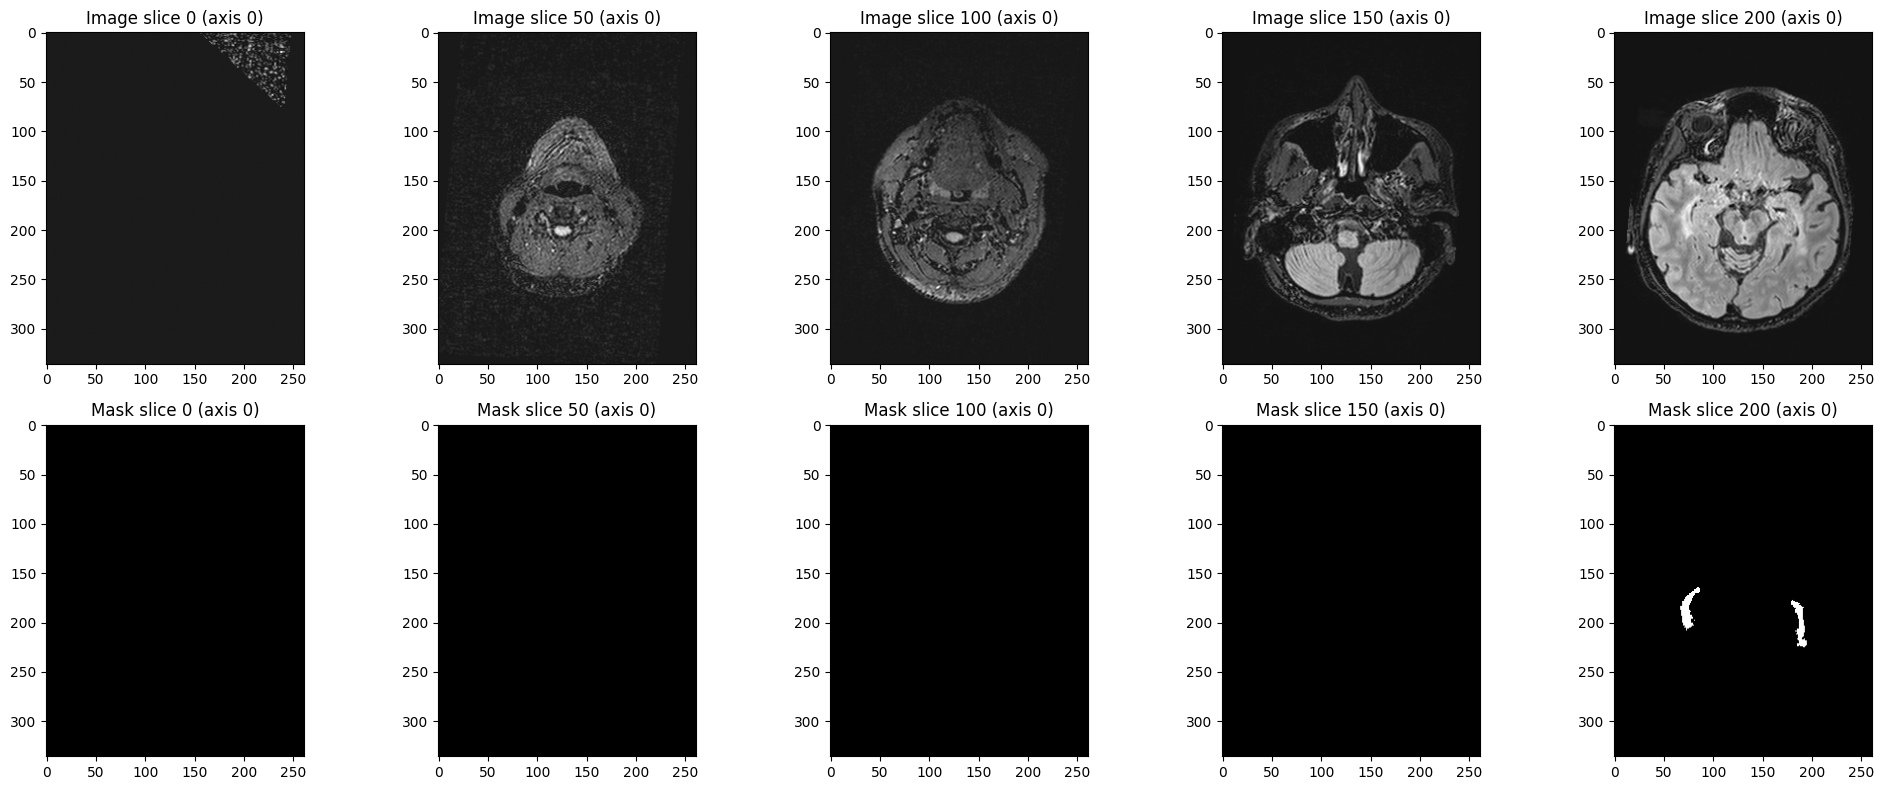

In [3]:
# Example usage:
visualize_slices('../data/01016SACH/3DFLAIR.nii', '../data/01016SACH/Consensus.nii', axis=0, indices=[0, 50, 100, 150, 200])

## Preprocess Data
Load and preprocess the `.nii` files into 3D tensors.

In [4]:
class BrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.patients = [os.path.join(root_dir, p) for p in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, p))]

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_dir = self.patients[idx]
        flair_path = os.path.join(patient_dir, '3DFLAIR.nii')
        mask_path = os.path.join(patient_dir, 'Consensus.nii')

        flair_img = sitk.GetArrayFromImage(sitk.ReadImage(flair_path))
        mask_img = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

        flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)  # Normalize
        mask_img = (mask_img > 0).astype(np.float32)  # Binarize

        if self.transform:
            flair_img, mask_img = self.transform(flair_img, mask_img)

        return torch.tensor(flair_img).unsqueeze(0), torch.tensor(mask_img).unsqueeze(0)

# Dataset and DataLoader
from sklearn.model_selection import train_test_split

# Dataset and DataLoader
root_dir = '../data'
dataset = BrainDataset(root_dir)

# Séparation explicite : 12 pour train, 3 pour val
num_total = len(dataset)
num_train = 12
num_val = num_total - num_train

indices = np.arange(num_total)
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices[:num_train]
val_indices = indices[num_train:]

# Vérification de l'absence de doublons
train_patients = set([dataset.patients[i] for i in train_indices])
val_patients = set([dataset.patients[i] for i in val_indices])
intersection = train_patients & val_patients
print(f"Doublons entre train et val : {intersection}")
assert len(intersection) == 0, "Il y a des doublons entre train et val !"

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

print(f"Nombre de patients dans le train_loader : {len(train_loader.dataset)}")
print(f"Nombre de patients dans le val_loader : {len(val_loader.dataset)}")

"""
print("Patients dans le train_loader :")
for idx in train_indices:
    patient_path = dataset.patients[idx]
    flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
    print(f"- {os.path.basename(patient_path)} : shape = {flair_img.shape}")

print("\nPatients dans le val_loader :")
for idx in val_indices:
    patient_path = dataset.patients[idx]
    flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
    print(f"- {os.path.basename(patient_path)} : shape = {flair_img.shape}")
"""

Doublons entre train et val : set()
Nombre de patients dans le train_loader : 12
Nombre de patients dans le val_loader : 3


'\nprint("Patients dans le train_loader :")\nfor idx in train_indices:\n    patient_path = dataset.patients[idx]\n    flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, \'3DFLAIR.nii\')))\n    print(f"- {os.path.basename(patient_path)} : shape = {flair_img.shape}")\n\nprint("\nPatients dans le val_loader :")\nfor idx in val_indices:\n    patient_path = dataset.patients[idx]\n    flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, \'3DFLAIR.nii\')))\n    print(f"- {os.path.basename(patient_path)} : shape = {flair_img.shape}")\n'

In [ ]:
print(dataset.patients)

In [5]:
# Affiche les patients de chaque loader et la taille de leur volume

print("Patients dans le train_loader :")
for idx in train_indices:
    patient_path = dataset.patients[idx]
    flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
    print(f"- {os.path.basename(patient_path)} : shape = {flair_img.shape}")

print("\nPatients dans le val_loader :")
for idx in val_indices:
    patient_path = dataset.patients[idx]
    flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
    print(f"- {os.path.basename(patient_path)} : shape = {flair_img.shape}")

Patients dans le train_loader :
- 07043SEME : shape = (336, 336, 261)
- 08027SYBR : shape = (336, 336, 261)
- 01016SACH : shape = (336, 336, 261)
- 08031SEVE : shape = (336, 336, 261)
- 07001MOEL : shape = (336, 336, 261)
- 07040DORE : shape = (336, 336, 261)
- 01039VITE : shape = (336, 336, 261)
- 01038PAGU : shape = (336, 336, 261)
- 08037ROGU : shape = (336, 336, 261)
- 01042GULE : shape = (336, 336, 261)
- 07010NABO : shape = (336, 336, 261)
- 08002CHJE : shape = (336, 336, 261)

Patients dans le val_loader :
- 08029IVDI : shape = (336, 336, 261)
- 01040VANE : shape = (336, 336, 261)
- 07003SATH : shape = (336, 336, 261)


## Define the 3D U-Net Model
Build the 3D U-Net architecture.

In [6]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.encoder1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.encoder3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool3d(2)

        # Bottleneck
        self.bottleneck = conv_block(128, 256)

        # Decoder
        self.upconv3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = conv_block(256, 128)
        self.upconv2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128, 64)
        self.upconv1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64, 32)

        self.output = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)
        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)
        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)

        b = self.bottleneck(p3)

        d3 = self.upconv3(b)
        # Resize d3 to match e3's size
        d3 = F.interpolate(d3, size=e3.shape[2:], mode='trilinear', align_corners=False)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        # Resize d2 to match e2's size
        d2 = F.interpolate(d2, size=e2.shape[2:], mode='trilinear', align_corners=False)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        # Resize d1 to match e1's size
        d1 = F.interpolate(d1, size=e1.shape[2:], mode='trilinear', align_corners=False)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        out = self.output(d1)
        return out

# Instantiate the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet3D(in_channels=1, out_channels=1).to(device)

## Training Parameters
Define all training parameters, loss function, and optimizer here for reuse.

In [7]:
# Training parameters
learning_rate = 0.001
num_epochs = 50
batch_size = 1

# Loss function
class DiceLoss(nn.Module):
    """
    Dice Loss for binary segmentation tasks.
    """
    def __init__(self, sigmoid=True):
        super(DiceLoss, self).__init__()
        self.sigmoid = sigmoid

    def forward(self, inputs, targets):
        if self.sigmoid:
            inputs = torch.sigmoid(inputs)
        smooth = 1e-8
        intersection = (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2.0 * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()

class ComboLoss(nn.Module):
    def __init__(self, dice_weight=0.7):
        super().__init__()
        self.dice = DiceLoss(sigmoid=True)
        self.bce = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight

    def forward(self, inputs, targets):
        dice_loss = self.dice(inputs, targets)
        bce_loss = self.bce(inputs, targets)
        return self.dice_weight * dice_loss + (1 - self.dice_weight) * bce_loss

criterion = ComboLoss(dice_weight=0.7)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train the Model
Train the 3D U-Net model with training and validation phases, and save the best model.

In [ ]:
%%time
import gc
from tqdm.auto import tqdm

# Initialize variables for tracking training
train_losses = []
valid_losses = []
best_valid_loss = float('inf')
best_model = None
best_epoch = 0

model.train()  # Set model to training mode

# Enable mixed precision training
scaler = torch.amp.GradScaler(device)

torch.cuda.empty_cache()

# Training loop with mixed precision and frequent cache clearing
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # Training Phase
    ###################
    model.train()
    for images, masks in tqdm(train_loader, desc='Training', leave=False):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.amp.autocast(device):
            outputs = model(images)
            loss = criterion(outputs, masks)

        # Backward pass with scaled gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * images.size(0)

        # Clear GPU cache after each batch
        torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    ###################
    # Validation Phase
    ###################
    model.eval()
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Validation', leave=False):
            images, masks = images.to(device), masks.to(device)

            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)

            valid_loss += loss.item() * images.size(0)

            # Clear GPU cache after each batch
            torch.cuda.empty_cache()

    valid_loss /= len(val_loader.dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = model.state_dict()
        best_epoch = epoch + 1

    # Clear GPU cache after each epoch
    torch.cuda.empty_cache()
    gc.collect()

print(f"✅ Best model saved at epoch {best_epoch} with validation loss: {best_valid_loss:.4f}")
torch.save(best_model, './50_epoch.pth')

# Train un modèle existant

In [ ]:
# Charger le modèle sauvegardé et poursuivre l'entraînement

learning_rate = 0.01

# Instanciation du modèle (doit correspondre à l'architecture utilisée)
model = UNet3D(in_channels=1, out_channels=1).to(device)

# Charger les poids sauvegardés
checkpoint_path = './50_epoch.pth'
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"Modèle chargé depuis {checkpoint_path}, poursuite de l'entraînement.")
else:
    print(f"Aucun fichier trouvé à {checkpoint_path}, initialisation d'un nouveau modèle.")

# Optimizer et criterion doivent être redéfinis pour ce modèle
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scaler = torch.amp.GradScaler(device)

# Définir le nombre d'époques supplémentaires à entraîner
num_epochs_finetune = 15  # à adapter selon besoin

# Listes pour suivre les pertes
train_losses_finetune = []
valid_losses_finetune = []

for epoch in range(num_epochs_finetune):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device):
            outputs = model(images)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item() * images.size(0)
        torch.cuda.empty_cache()
    train_loss /= len(train_loader.dataset)
    train_losses_finetune.append(train_loss)

    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            with torch.amp.autocast(device):
                outputs = model(images)
                loss = criterion(outputs, masks)
            valid_loss += loss.item() * images.size(0)
            torch.cuda.empty_cache()
    valid_loss /= len(val_loader.dataset)
    valid_losses_finetune.append(valid_loss)

    print(f"[Finetune] Epoch {epoch+1}/{num_epochs_finetune} - Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

# Sauvegarde du modèle affiné
torch.save(model.state_dict(), './finetuned_3d_unet.pth')
print("Modèle affiné sauvegardé sous ./finetuned_3d_unet.pth")

## Display Training Curves
Visualize the training and validation loss curves.

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(train_losses_finetune, label='Training Loss')
plt.plot(valid_losses_finetune, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Evaluate the Model
Evaluate the model's performance on the validation set.

In [ ]:
torch.cuda.empty_cache()
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
val_loss = 0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

val_loss /= len(val_loader)
print(f"Validation Loss: {val_loss:.4f}")

## Save the Model
Save the trained 3D U-Net model to a file for later use.

In [ ]:
model_path = './3d_unet_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [ ]:
# Déplace le modèle sur CPU AVANT d'appeler state_dict
model_cpu = model.to('cpu')
torch.save(model_cpu.state_dict(), './3d_unet_model.pth')

# Libère mémoire GPU
del model
torch.cuda.empty_cache()

## Load and Test the Model

In [ ]:
# Load the best model
model.load_state_dict(torch.load('../Modèles/3D/50_epoch.pth'))
model = model.to(device)
model.eval()

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def plot_3d_slice(images, masks, predictions, slice_idx, dice, iou):
    """Visualize a slice from the 3D volume."""
    image = images[0, 0, slice_idx].cpu().numpy()
    mask = masks[0, 0, slice_idx].cpu().numpy()
    prediction = predictions[0, 0, slice_idx].cpu().numpy()

    # Normalize image for visualization
    image = (image - image.min()) / (image.max() - image.min() + 1e-8)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(mask, cmap='jet')
    axes[0, 1].set_title('Ground Truth Mask')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(prediction, cmap='jet')
    axes[0, 2].set_title(f'Predicted Mask\nDice: {dice:.3f} | IoU: {iou:.3f}')
    axes[0, 2].axis('off')

    axes[1, 0].imshow(image, cmap='gray')
    axes[1, 0].set_title('Original Image')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(image, cmap='gray')
    axes[1, 1].imshow(mask, cmap='Reds', alpha=0.4)
    axes[1, 1].set_title('Overlay Ground Truth')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(image, cmap='gray')
    axes[1, 2].imshow(prediction, cmap='Blues', alpha=0.4)
    axes[1, 2].set_title('Overlay Prediction')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
print(images.shape[2])

In [ ]:
# Select a random patient and slice
random_patient_idx = random.randint(0, len(val_loader) - 1)
random_patient_idx = 1
print(random_patient_idx)

for random_patient_idx in [0, 1, 2] :

    batch = list(val_loader)[random_patient_idx]
    images, masks = batch
    images, masks = images.to(device), masks.to(device)

    random_slice_idx = random.randint(150, images.shape[2] - 50)
    random_slice_idx = 250
    print(random_slice_idx)


    for i in np.arange(0.1, 1.1, 0.1) :
        print(i)
        # Get predictions
        with torch.no_grad():
            predictions = torch.sigmoid(model(images)) > i

            # Calculate Dice and IoU
            intersection = (predictions[0, 0, random_slice_idx] * masks[0, 0, random_slice_idx]).sum().item()
            dice = (2.0 * intersection) / (predictions[0, 0, random_slice_idx].sum().item() + masks[0, 0, random_slice_idx].sum().item() + 1e-8)
            iou = intersection / ((predictions[0, 0, random_slice_idx] + masks[0, 0, random_slice_idx]).clamp(0, 1).sum().item() + 1e-8)

        # Visualize the randomly selected slice
        plot_3d_slice(images, masks, predictions, random_slice_idx, dice, iou)

    print("\n")

In [ ]:
from tqdm.auto import tqdm

def calculate_metrics(loader, model):
    model.eval()
    dice_scores = []
    iou_scores = []

    for threshold in np.arange(0.1, 0.5, 0.1) :
        with torch.no_grad():
            for images, masks in tqdm(loader, desc='Calculating Metrics'):
                images, masks = images.to(device), masks.to(device)
                predictions = torch.sigmoid(model(images)) > threshold

                for i in range(images.size(0)):
                    intersection = (predictions[i] * masks[i]).sum().item()
                    dice = (2.0 * intersection) / (predictions[i].sum().item() + masks[i].sum().item() + 1e-8)
                    iou = intersection / ((predictions[i] + masks[i]).clamp(0, 1).sum().item() + 1e-8)

                    dice_scores.append(dice)
                    iou_scores.append(iou)

        avg_dice = sum(dice_scores) / len(dice_scores)
        avg_iou = sum(iou_scores) / len(iou_scores)

        print(f"Threshold: {threshold:.3f}")
        print(f"Average Dice: {avg_dice:.4f}")
        print(f"Average IoU: {avg_iou:.4f}")
        print("\n")

    return avg_dice, avg_iou

In [ ]:
# Calculate metrics on the validation set
avg_dice, avg_iou = calculate_metrics(val_loader, model)

In [ ]:
# Calculate metrics on the training set
avg_dice, avg_iou = calculate_metrics(train_loader, model)

In [ ]:
import numpy as np
from tqdm.auto import tqdm

# Dictionnaire pour stocker les meilleurs scores par patient
patient_best_scores = {}

model.eval()
with torch.no_grad():
    for idx in tqdm(indices, desc="Patients"): 
        patient_path = dataset.patients[idx]
        patient_name = os.path.basename(patient_path)
        flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
        mask_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, 'Consensus.nii')))
        flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
        mask_img = (mask_img > 0).astype(np.float32)
        # Ajoute batch et channel dims
        flair_tensor = torch.tensor(flair_img).unsqueeze(0).unsqueeze(0).to(device)
        mask_tensor = torch.tensor(mask_img).unsqueeze(0).unsqueeze(0).to(device)


        outputs = torch.sigmoid(model(flair_tensor))
        threshold = 0.1
        preds = (outputs > threshold).float()
        # Calcul sur toutes les slices
        intersection = (preds * mask_tensor).sum().item()
        dice = (2.0 * intersection) / (preds.sum().item() + mask_tensor.sum().item() + 1e-8)
        iou = intersection / ((preds + mask_tensor).clamp(0, 1).sum().item() + 1e-8)

        patient_best_scores[patient_name] = {
            'dice': dice,
            'iou': iou,
            'threshold': threshold
        }

print("Meilleurs scores par patient (train set) :")
for k, v in patient_best_scores.items():
    print(f"{k}: Dice={v['dice']:.4f}, IoU={v['iou']:.4f}, Threshold={v['threshold']:.2f}")

In [ ]:
# Sauvegarde
import json
with open('patient_best_scores.json', 'w') as f:
    json.dump(patient_best_scores, f)

### Dice

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Préparer les données pour le plot
patient_names = list(patient_best_scores.keys())
dice_scores = [patient_best_scores[name]['dice'] for name in patient_names]

# Déterminer la couleur selon l'appartenance au set
colors = []
for name in patient_names:
    idx = dataset.patients.index(os.path.join(root_dir, name))
    if idx in train_indices:
        colors.append('red')
    else:
        colors.append('green')

plt.figure(figsize=(12, 4))
bars = plt.bar(patient_names, dice_scores, color=colors)
plt.ylim(0, 1)
plt.ylabel('Dice')
plt.xlabel('Patient')
plt.title('Dice par patient')
plt.xticks(rotation=45, ha='right')

# Ajouter la légende
red_patch = mpatches.Patch(color='red', label='Train')
green_patch = mpatches.Patch(color='green', label='Validation')
plt.legend(handles=[red_patch, green_patch], title="Légende")

plt.tight_layout()
plt.show()

### IoU

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Préparer les données pour le plot IoU
iou_scores = [patient_best_scores[name]['iou'] for name in patient_names]

plt.figure(figsize=(12, 4))
bars = plt.bar(patient_names, iou_scores, color=colors)
plt.ylim(0, 1)
plt.ylabel('IoU')
plt.xlabel('Patient')
plt.title('IoU par patient')
plt.xticks(rotation=45, ha='right')

# Ajouter la légende
red_patch = mpatches.Patch(color='red', label='Train')
green_patch = mpatches.Patch(color='green', label='Validation')
plt.legend(handles=[red_patch, green_patch], title="(rouge : train, vert:validation)")

plt.tight_layout()
plt.show()

##### Tracé du dice et le IoU d'un patient random du set de validation en fonction du seuil de binarisation du résultat du modèle

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Sélectionner un patient du validation set au hasard
random_val_idx = random.choice(val_indices)
patient_path = dataset.patients[random_val_idx]
patient_name = os.path.basename(patient_path)

# Charger les images et masques
flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
mask_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, 'Consensus.nii')))
flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
mask_img = (mask_img > 0).astype(np.float32)
flair_tensor = torch.tensor(flair_img).unsqueeze(0).unsqueeze(0).to(device)
mask_tensor = torch.tensor(mask_img).unsqueeze(0).unsqueeze(0).to(device)

# Calculer Dice et IoU pour plusieurs thresholds
thresholds = np.arange(0.05, 1.05, 0.05)
dice_list = []
iou_list = []

model.eval()
with torch.no_grad():
    outputs = torch.sigmoid(model(flair_tensor))
    for t in thresholds:
        preds = (outputs > t).float()
        intersection = (preds * mask_tensor).sum().item()
        dice = (2.0 * intersection) / (preds.sum().item() + mask_tensor.sum().item() + 1e-8)
        iou = intersection / ((preds + mask_tensor).clamp(0, 1).sum().item() + 1e-8)
        dice_list.append(dice)
        iou_list.append(iou)


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, dice_list, label='Dice')
plt.plot(thresholds, iou_list, label='IoU')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'Dice et IoU pour différents thresholds\nPatient validation: {patient_name}')
plt.ylim(0, 0.05)
plt.legend()
plt.grid()
plt.show()

#### Distance de Hausdorf

In [ ]:
import scipy.ndimage
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(mask1, mask2):
    """
    Calcule la distance de Hausdorff entre deux masques binaires 3D.
    """
    # Obtenir les coordonnées des voxels non nuls
    coords1 = np.argwhere(mask1)
    coords2 = np.argwhere(mask2)
    if coords1.size == 0 or coords2.size == 0:
        return np.nan  # Pas de structure à comparer
    hd1 = directed_hausdorff(coords1, coords2)[0]
    hd2 = directed_hausdorff(coords2, coords1)[0]
    return max(hd1, hd2)

In [ ]:
# Exemple sur un patient du set de validation
random_val_idx = random.choice(val_indices)
patient_path = dataset.patients[random_val_idx]
flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
mask_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, 'Consensus.nii')))
flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
mask_img = (mask_img > 0).astype(np.uint8)
flair_tensor = torch.tensor(flair_img).unsqueeze(0).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    outputs = torch.sigmoid(model(flair_tensor)).cpu().numpy()[0,0]
    threshold = 0.1
    pred_mask = (outputs > threshold).astype(np.uint8)

hausdorff = hausdorff_distance(mask_img, pred_mask)
print(f"Hausdorff distance (patient {os.path.basename(patient_path)}): {hausdorff:.2f} voxels")

In [ ]:
# Calcul de la distance de Hausdorff pour tous les patients et ajout dans patient_best_scores

for patient_name in patient_best_scores:
    patient_path = os.path.join(root_dir, patient_name)
    flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
    mask_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, 'Consensus.nii')))
    flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
    mask_img = (mask_img > 0).astype(np.uint8)
    flair_tensor = torch.tensor(flair_img).unsqueeze(0).unsqueeze(0).to(device)

    threshold = patient_best_scores[patient_name]['threshold']
    model.eval()
    with torch.no_grad():
        outputs = torch.sigmoid(model(flair_tensor)).cpu().numpy()[0,0]
        pred_mask = (outputs > threshold).astype(np.uint8)

    hd = hausdorff_distance(mask_img, pred_mask)
    patient_best_scores[patient_name]['hausdorff'] = float(hd)

print("Hausdorff distances ajoutées à patient_best_scores.")

# Ajout : sauvegarde du dictionnaire mis à jour
import json
with open('patient_best_scores.json', 'w') as f:
    json.dump(patient_best_scores, f)

In [ ]:
# Ajoute le type de dataset ("train" ou "val") à chaque patient dans patient_best_scores
for patient_name in patient_best_scores:
    idx = dataset.patients.index(os.path.join(root_dir, patient_name))
    if idx in train_indices:
        patient_best_scores[patient_name]['type'] = 'train'
    else:
        patient_best_scores[patient_name]['type'] = 'val'

# Sauvegarde le dictionnaire mis à jour
import json
with open('patient_best_scores.json', 'w') as f:
    json.dump(patient_best_scores, f)

### Ajout de nouvelles métriques

Précision (Precision) : proportion de voxels prédits positifs qui sont réellement positifs.

Rappel (Recall) / Sensibilité (Sensitivity) : proportion de voxels positifs correctement détectés.

Spécificité (Specificity) : proportion de voxels négatifs correctement détectés.

FPR (False Positive Rate) : taux de faux positifs.

FNR (False Negative Rate) : taux de faux négatifs.

In [ ]:
import json
import numpy as np

# Charger le dictionnaire patient_best_scores
with open('patient_best_scores.json', 'r') as f:
    patient_best_scores = json.load(f)

for patient_name in patient_best_scores:
    patient_path = os.path.join(root_dir, patient_name)
    flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
    mask_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, 'Consensus.nii')))
    flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
    mask_img = (mask_img > 0).astype(np.uint8)
    flair_tensor = torch.tensor(flair_img).unsqueeze(0).unsqueeze(0).to(device)

    threshold = patient_best_scores[patient_name]['threshold']
    model.eval()
    with torch.no_grad():
        outputs = torch.sigmoid(model(flair_tensor)).cpu().numpy()[0,0]
        pred_mask = (outputs > threshold).astype(np.uint8)

    # Calcul des métriques
    TP = np.logical_and(pred_mask == 1, mask_img == 1).sum()
    TN = np.logical_and(pred_mask == 0, mask_img == 0).sum()
    FP = np.logical_and(pred_mask == 1, mask_img == 0).sum()
    FN = np.logical_and(pred_mask == 0, mask_img == 1).sum()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)
    fpr = FP / (FP + TN + 1e-8)
    fnr = FN / (FN + TP + 1e-8)

    patient_best_scores[patient_name]['precision'] = float(precision)
    patient_best_scores[patient_name]['recall'] = float(recall)
    patient_best_scores[patient_name]['specificity'] = float(specificity)
    patient_best_scores[patient_name]['fpr'] = float(fpr)
    patient_best_scores[patient_name]['fnr'] = float(fnr)

# Sauvegarde le dictionnaire mis à jour
with open('patient_best_scores.json', 'w') as f:
    json.dump(patient_best_scores, f)

### Print des infos globales

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Charger les scores
with open('patient_best_scores_50epoch.json', 'r') as f:
    patient_best_scores = json.load(f)

patient_names = list(patient_best_scores.keys())
metrics = ['dice', 'iou', 'precision', 'recall', 'specificity', 'fpr', 'fnr', 'hausdorff']
colors = ['red' if patient_best_scores[name]['type'] == 'train' else 'green' for name in patient_names]

fig, axes = plt.subplots(2, 4, figsize=(22, 8))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    values = [patient_best_scores[name][metric] for name in patient_names]
    axes[i].bar(patient_names, values, color=colors)
    axes[i].set_title(metric.capitalize())
    axes[i].set_xticklabels(patient_names, rotation=45, ha='right')
    axes[i].set_ylim(0, 1 if metric != 'hausdorff' else None)
    axes[i].grid(True, axis='y')

# Légende
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Train')
green_patch = mpatches.Patch(color='green', label='Validation')
fig.legend(handles=[red_patch, green_patch], title="Dataset", loc='upper right')

plt.tight_layout()
plt.show()

# Crée le json complet

In [ ]:
# Génère un fichier patient_best_scores_50epoch.json avec toutes les métriques en utilisant le modèle 50_epoch.pth

import json
import numpy as np

# Charger le modèle 50_epoch.pth
model_50 = UNet3D(in_channels=1, out_channels=1).to(device)
model_50.load_state_dict(torch.load('./50_epoch.pth', map_location=device))
model_50.eval()

patient_best_scores_50 = {}

with torch.no_grad():
    for idx in indices:
        patient_path = dataset.patients[idx]
        patient_name = os.path.basename(patient_path)
        flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
        mask_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, 'Consensus.nii')))
        flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
        mask_img_bin = (mask_img > 0).astype(np.uint8)
        flair_tensor = torch.tensor(flair_img).unsqueeze(0).unsqueeze(0).to(device)
        mask_tensor = torch.tensor(mask_img_bin).unsqueeze(0).unsqueeze(0).to(device)

        outputs = torch.sigmoid(model_50(flair_tensor))
        threshold = 0.1
        preds = (outputs > threshold).float()

        # Dice & IoU
        intersection = (preds * mask_tensor).sum().item()
        dice = (2.0 * intersection) / (preds.sum().item() + mask_tensor.sum().item() + 1e-8)
        iou = intersection / ((preds + mask_tensor).clamp(0, 1).sum().item() + 1e-8)

        # Hausdorff
        from scipy.spatial.distance import directed_hausdorff
        coords1 = np.argwhere(mask_img_bin)
        coords2 = np.argwhere(preds.cpu().numpy()[0,0])
        if coords1.size == 0 or coords2.size == 0:
            hausdorff = float('nan')
        else:
            hd1 = directed_hausdorff(coords1, coords2)[0]
            hd2 = directed_hausdorff(coords2, coords1)[0]
            hausdorff = float(max(hd1, hd2))

        # Précision, rappel, spécificité, FPR, FNR
        pred_mask = preds.cpu().numpy()[0,0].astype(np.uint8)
        TP = np.logical_and(pred_mask == 1, mask_img_bin == 1).sum()
        TN = np.logical_and(pred_mask == 0, mask_img_bin == 0).sum()
        FP = np.logical_and(pred_mask == 1, mask_img_bin == 0).sum()
        FN = np.logical_and(pred_mask == 0, mask_img_bin == 1).sum()
        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        specificity = TN / (TN + FP + 1e-8)
        fpr = FP / (FP + TN + 1e-8)
        fnr = FN / (FN + TP + 1e-8)

        # Type (train/val)
        idx_in_dataset = dataset.patients.index(patient_path)
        if idx_in_dataset in train_indices:
            set_type = 'train'
        else:
            set_type = 'val'

        patient_best_scores_50[patient_name] = {
            'dice': float(dice),
            'iou': float(iou),
            'threshold': float(threshold),
            'hausdorff': hausdorff,
            'type': set_type,
            'precision': float(precision),
            'recall': float(recall),
            'specificity': float(specificity),
            'fpr': float(fpr),
            'fnr': float(fnr)
        }

# Sauvegarde
with open('patient_best_scores_50epoch.json', 'w') as f:
    json.dump(patient_best_scores_50, f)
print("patient_best_scores_50epoch.json généré.")

In [ ]:
import SimpleITK as sitk
import torch
import numpy as np
import os

# Charger le modèle 50_epoch.pth
model = UNet3D(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load('../Modèles/3D/50_epoch.pth', map_location=device))
model.eval()

# Chemin du patient ROGU
patient_name = "08037ROGU"
patient_path = os.path.join(root_dir, patient_name)
flair_path = os.path.join(patient_path, '3DFLAIR.nii')
mask_path = os.path.join(patient_path, 'Consensus.nii')

# Charger l'image d'origine (pour garder la géométrie)
flair_img_sitk = sitk.ReadImage(flair_path)
flair_img_np = sitk.GetArrayFromImage(flair_img_sitk)
flair_img_norm = (flair_img_np - np.min(flair_img_np)) / (np.max(flair_img_np) - np.min(flair_img_np) + 1e-8)
flair_tensor = torch.tensor(flair_img_norm).unsqueeze(0).unsqueeze(0).to(device)

# Appliquer le modèle
with torch.no_grad():
    output = torch.sigmoid(model(flair_tensor)).cpu().numpy()[0,0]
    threshold = 0.4  # à ajuster selon vos résultats
    pred_mask = (output > threshold).astype(np.uint8)

# Convertir la prédiction en image SimpleITK (attention à l'ordre des axes)
pred_mask_sitk = sitk.GetImageFromArray(pred_mask)
pred_mask_sitk.CopyInformation(flair_img_sitk)  # pour garder le même espace/affine

# Sauvegarder le mask prédictif
output_path = os.path.join(patient_path, 'PredictedMask_ROGU.nii')
sitk.WriteImage(pred_mask_sitk, output_path)
print(f"Mask prédictif sauvegardé sous : {output_path}")

# Calculer le Dice entre le mask prédictif et le mask de vérité terrain
mask_img_sitk = sitk.ReadImage(mask_path)
mask_img_np = sitk.GetArrayFromImage(mask_img_sitk)
mask_bin = (mask_img_np > 0).astype(np.uint8)

intersection = (pred_mask * mask_bin).sum()
dice = (2.0 * intersection) / (pred_mask.sum() + mask_bin.sum() + 1e-8)
print(f"Dice du mask prédictif sauvegardé : {dice:.4f}")

### Pour avoir un affichage

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Lister tous les modèles dans Modèles/3D
models_dir = os.path.join('..', 'Modèles', '3D')
model_files = [f for f in os.listdir(models_dir) if f.endswith('.pth')]
model_files.sort()  # Pour un affichage cohérent

# 2. Liste des patients (utilise dataset.patients déjà construite)
patient_paths = dataset.patients
patient_names = [os.path.basename(p) for p in patient_paths]

# 3. Matrices pour stocker les scores
dice_matrix = np.zeros((len(model_files), len(patient_names)))
iou_matrix = np.zeros((len(model_files), len(patient_names)))

# 4. Boucle sur chaque modèle et chaque patient
for m_idx, model_file in enumerate(model_files):
    model_path = os.path.join(models_dir, model_file)
    try:
        state_dict = torch.load(model_path, map_location=device)
        model_tmp = UNet3D(in_channels=1, out_channels=1).to(device)
        model_tmp.load_state_dict(state_dict)
    except Exception as e:
        print(f"⚠️ Erreur lors du chargement de {model_file} : {e}")
        continue

    model_tmp.eval()
    with torch.no_grad():
        for p_idx, patient_path in enumerate(patient_paths):
            flair_path = os.path.join(patient_path, '3DFLAIR.nii')
            mask_path = os.path.join(patient_path, 'Consensus.nii')
            flair_img = sitk.GetArrayFromImage(sitk.ReadImage(flair_path))
            mask_img = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
            flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
            mask_img_bin = (mask_img > 0).astype(np.uint8)
            flair_tensor = torch.tensor(flair_img).unsqueeze(0).unsqueeze(0).to(device)
            mask_tensor = torch.tensor(mask_img_bin).unsqueeze(0).unsqueeze(0).to(device)

            outputs = torch.sigmoid(model_tmp(flair_tensor))
            threshold = 0.4
            preds = (outputs > threshold).float()

            intersection = (preds * mask_tensor).sum().item()
            dice = (2.0 * intersection) / (preds.sum().item() + mask_tensor.sum().item() + 1e-8)
            iou = intersection / ((preds + mask_tensor).clamp(0, 1).sum().item() + 1e-8)

            dice_matrix[m_idx, p_idx] = dice
            iou_matrix[m_idx, p_idx] = iou

    del model_tmp
    torch.cuda.empty_cache()

# 5. Affichage matplotlib
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Dice
im1 = axes[0].imshow(dice_matrix, aspect='auto', cmap='viridis', vmin=0, vmax=1)
axes[0].set_title('Dice par modèle et patient')
axes[0].set_ylabel('Modèle')
axes[0].set_yticks(np.arange(len(model_files)))
axes[0].set_yticklabels(model_files)
axes[0].set_xticks(np.arange(len(patient_names)))
axes[0].set_xticklabels(patient_names, rotation=45, ha='right')
fig.colorbar(im1, ax=axes[0], label='Dice')

# IoU
im2 = axes[1].imshow(iou_matrix, aspect='auto', cmap='magma', vmin=0, vmax=1)
axes[1].set_title('IoU par modèle et patient')
axes[1].set_ylabel('Modèle')
axes[1].set_xlabel('Patient')
axes[1].set_yticks(np.arange(len(model_files)))
axes[1].set_yticklabels(model_files)
axes[1].set_xticks(np.arange(len(patient_names)))
axes[1].set_xticklabels(patient_names, rotation=45, ha='right')
fig.colorbar(im2, ax=axes[1], label='IoU')

plt.tight_layout()
plt.show()

In [ ]:
import json

# Sauvegarde des matrices et des noms pour réutilisation ultérieure
results_dict = {
    "model_files": model_files,
    "patient_names": patient_names,
    "dice_matrix": dice_matrix.tolist(),
    "iou_matrix": iou_matrix.tolist()
}
with open("dice_iou_by_model_patient.json", "w") as f:
    json.dump(results_dict, f)
print("Matrices Dice/IoU sauvegardées dans dice_iou_by_model_patient.json")

# Affichage plus lisible : courbes par patient
import matplotlib.pyplot as plt
import numpy as np

dice_matrix = np.array(dice_matrix)
iou_matrix = np.array(iou_matrix)

# Détermine le type (train/val) pour chaque patient
patient_types = []
for name in patient_names:
    idx = dataset.patients.index(os.path.join(root_dir, name))
    if idx in train_indices:
        patient_types.append('train')
    else:
        patient_types.append('val')

colors = ['red' if t == 'train' else 'green' for t in patient_types]

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Courbes Dice
for p_idx, name in enumerate(patient_names):
    axes[0].plot(model_files, dice_matrix[:, p_idx], marker='o', color=colors[p_idx], label=name)
axes[0].set_title('Dice par patient selon le modèle')
axes[0].set_ylabel('Dice')
axes[0].set_ylim(0, 1)
axes[0].grid(True, axis='y')
# Légende personnalisée
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Train'),
    Line2D([0], [0], color='green', lw=2, label='Validation')
]
axes[0].legend(handles=legend_elements, loc='upper left', title="Type de patient")

# Courbes IoU
for p_idx, name in enumerate(patient_names):
    axes[1].plot(model_files, iou_matrix[:, p_idx], marker='o', color=colors[p_idx], label=name)
axes[1].set_title('IoU par patient selon le modèle')
axes[1].set_ylabel('IoU')
axes[1].set_xlabel('Modèle')
axes[1].set_ylim(0, 1)
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# 5. Affichage matplotlib avec colormap rouge-jaune-vert
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Définir une colormap rouge-jaune-vert
cmap_rjyv = mcolors.LinearSegmentedColormap.from_list(
    "rjyv", ["red", "yellow", "green"]
)

fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Dice
im1 = axes[0].imshow(dice_matrix, aspect='auto', cmap=cmap_rjyv, vmin=0, vmax=1)
axes[0].set_title('Dice par modèle et patient')
axes[0].set_ylabel('Modèle')
axes[0].set_yticks(np.arange(len(model_files)))
axes[0].set_yticklabels(model_files)
axes[0].set_xticks(np.arange(len(patient_names)))
axes[0].set_xticklabels(patient_names, rotation=45, ha='right')
fig.colorbar(im1, ax=axes[0], label='Dice')

# IoU
im2 = axes[1].imshow(iou_matrix, aspect='auto', cmap=cmap_rjyv, vmin=0, vmax=1)
axes[1].set_title('IoU par modèle et patient')
axes[1].set_ylabel('Modèle')
axes[1].set_xlabel('Patient')
axes[1].set_yticks(np.arange(len(model_files)))
axes[1].set_yticklabels(model_files)
axes[1].set_xticks(np.arange(len(patient_names)))
axes[1].set_xticklabels(patient_names, rotation=45, ha='right')
fig.colorbar(im2, ax=axes[1], label='IoU')

plt.tight_layout()
plt.show()

## Modèle U-Net 3D profond, BCE, SGD, nouvelle répartition aléatoire

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

# U-Net 3D plus profond
class DeepUNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        # Encoder (4 niveaux)
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool3d(2)
        self.enc4 = conv_block(128, 256)
        self.pool4 = nn.MaxPool3d(2)
        # Bottleneck
        self.bottleneck = conv_block(256, 512)
        # Decoder (4 niveaux)
        self.up4 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.dec4 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = conv_block(64, 32)
        self.out_conv = nn.Conv3d(32, out_channels, kernel_size=1)
    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        b = self.bottleneck(p4)
        d4 = self.up4(b)
        d4 = F.interpolate(d4, size=e4.shape[2:], mode='trilinear', align_corners=False)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = F.interpolate(d3, size=e3.shape[2:], mode='trilinear', align_corners=False)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = F.interpolate(d2, size=e2.shape[2:], mode='trilinear', align_corners=False)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = F.interpolate(d1, size=e1.shape[2:], mode='trilinear', align_corners=False)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.out_conv(d1)


In [9]:

# Nouvelle répartition aléatoire des patients
root_dir = '../data'
dataset = BrainDataset(root_dir)
num_total = len(dataset)
split_ratio = 0.8
num_train = int(num_total * split_ratio)
num_val = num_total - num_train

indices_new = np.arange(num_total)
np.random.seed()  # Différent à chaque exécution
np.random.shuffle(indices_new)
train_indices_new = indices_new[:num_train]
val_indices_new = indices_new[num_train:]

train_dataset_new = torch.utils.data.Subset(dataset, train_indices_new)
val_dataset_new = torch.utils.data.Subset(dataset, val_indices_new)
train_loader_new = DataLoader(train_dataset_new, batch_size=1, shuffle=True)
val_loader_new = DataLoader(val_dataset_new, batch_size=1, shuffle=False)

print(f"Nouvelle répartition : {len(train_loader_new.dataset)} train, {len(val_loader_new.dataset)} val")

# Modèle, loss ComboLoss, SGD, lr=0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
deep_model = DeepUNet3D(in_channels=1, out_channels=1).to(device)
deep_criterion = ComboLoss(dice_weight=0.7)  # Utilise ComboLoss au lieu de BCE
sgd_optimizer = torch.optim.SGD(deep_model.parameters(), lr=0.001, momentum=0.9)

print("Modèle DeepUNet3D, loss=ComboLoss, optim=SGD, lr=0.001 prêt.")

Nouvelle répartition : 12 train, 3 val
Modèle DeepUNet3D, loss=ComboLoss, optim=SGD, lr=0.001 prêt.


In [ ]:
# Entraînement du DeepUNet3D avec ComboLoss et SGD, nouvelle répartition
import gc
from tqdm.auto import tqdm

num_epochs_deep = 20

train_losses_deep = []
valid_losses_deep = []
best_valid_loss_deep = float('inf')
best_model_deep = None
best_epoch_deep = 0

deep_model.train()
scaler_deep = torch.amp.GradScaler(device)
torch.cuda.empty_cache()

for epoch in tqdm(range(num_epochs_deep), desc='Epochs'):
    train_loss = 0.0
    valid_loss = 0.0

    # Phase entraînement
    deep_model.train()
    train_dice = []
    for images, masks in tqdm(train_loader_new, desc='Training', leave=False):
        images, masks = images.to(device), masks.to(device)
        sgd_optimizer.zero_grad()
        with torch.amp.autocast(device):
            outputs = deep_model(images)
            loss = deep_criterion(outputs, masks)  # Utilise ComboLoss
        scaler_deep.scale(loss).backward()
        scaler_deep.step(sgd_optimizer)
        scaler_deep.update()
        train_loss += loss.item() * images.size(0)
        # Calcul du Dice pour ce batch
        preds = (torch.sigmoid(outputs) > 0.1).float()
        intersection = (preds * masks).sum().item()
        dice = (2.0 * intersection) / (preds.sum().item() + masks.sum().item() + 1e-8)
        train_dice.append(dice)
        torch.cuda.empty_cache()
    train_loss /= len(train_loader_new.dataset)
    train_dice_mean = np.mean(train_dice)
    train_losses_deep.append(train_loss)

    # Phase validation
    deep_model.eval()
    val_dice = []
    with torch.no_grad():
        for images, masks in tqdm(val_loader_new, desc='Validation', leave=False):
            images, masks = images.to(device), masks.to(device)
            with torch.amp.autocast(device):
                outputs = deep_model(images)
                loss = deep_criterion(outputs, masks)  # Utilise ComboLoss
            valid_loss += loss.item() * images.size(0)
            # Calcul du Dice pour ce batch
            preds = (torch.sigmoid(outputs) > 0.1).float()
            intersection = (preds * masks).sum().item()
            dice = (2.0 * intersection) / (preds.sum().item() + masks.sum().item() + 1e-8)
            val_dice.append(dice)
            torch.cuda.empty_cache()
    valid_loss /= len(val_loader_new.dataset)
    val_dice_mean = np.mean(val_dice)
    valid_losses_deep.append(valid_loss)

    print(f"[DeepUNet3D] Epoch {epoch+1}/{num_epochs_deep} - Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f} | Train Dice: {train_dice_mean:.4f}, Val Dice: {val_dice_mean:.4f}")

    if valid_loss < best_valid_loss_deep:
        best_valid_loss_deep = valid_loss
        best_model_deep = deep_model.state_dict()
        best_epoch_deep = epoch + 1

    torch.cuda.empty_cache()
    gc.collect()

print(f"✅ Best DeepUNet3D model saved at epoch {best_epoch_deep} with validation loss: {best_valid_loss_deep:.4f}")
torch.save(best_model_deep, '../Modèles/3D/deep_3d_20_epoch.pth')

In [12]:
import torch
import gc
from tqdm.auto import tqdm

# 1. Charger le modèle initial (architecture identique à l'entraînement initial)
deep_model = DeepUNet3D(in_channels=1, out_channels=1).to(device)
deep_model.load_state_dict(torch.load('../Modèles/3D/deep_3d_20_epoch_+_25.pth', map_location=device))
print("Modèle /deep_3d_20_epoch_+_25.pth chargé.")

# 2. Sauvegarder une copie des poids AVANT fine-tuning (pour revenir en arrière si besoin)
import copy
deep_model_initial = copy.deepcopy(deep_model)  # deep_model_initial = modèle avant reprise

# 3. Optimizer et scaler
sgd_optimizer = torch.optim.SGD(deep_model.parameters(), lr=0.002, momentum=0.9)  # lr adapté si besoin
scaler_deep = torch.amp.GradScaler(device)
deep_criterion = ComboLoss(dice_weight=0.6)

# 4. Boucle de fine-tuning
num_epochs_finetune = 25  # à adapter
train_losses_finetune = []
valid_losses_finetune = []

for epoch in tqdm(range(num_epochs_finetune), desc='Finetune Epochs'):
    train_loss = 0.0
    valid_loss = 0.0

    deep_model.train()
    for images, masks in tqdm(train_loader_new, desc='Training', leave=False):
        images, masks = images.to(device), masks.to(device)
        sgd_optimizer.zero_grad()
        with torch.amp.autocast(device):
            outputs = deep_model(images)
            loss = deep_criterion(outputs, masks)
        scaler_deep.scale(loss).backward()
        scaler_deep.step(sgd_optimizer)
        scaler_deep.update()
        train_loss += loss.item() * images.size(0)
        torch.cuda.empty_cache()
    train_loss /= len(train_loader_new.dataset)
    train_losses_finetune.append(train_loss)

    deep_model.eval()
    with torch.no_grad():
        for images, masks in tqdm(val_loader_new, desc='Validation', leave=False):
            images, masks = images.to(device), masks.to(device)
            with torch.amp.autocast(device):
                outputs = deep_model(images)
                loss = deep_criterion(outputs, masks)
            valid_loss += loss.item() * images.size(0)
            torch.cuda.empty_cache()
    valid_loss /= len(val_loader_new.dataset)
    valid_losses_finetune.append(valid_loss)

    print(f"[Finetune] Epoch {epoch+1}/{num_epochs_finetune} - Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    torch.cuda.empty_cache()
    gc.collect()

# 5. Sauvegarde du modèle fine-tuné
torch.save(deep_model.state_dict(), '../Modèles/3D/deep_3d_20_epoch+25+25.pth')
print("Modèle fine-tuné sauvegardé sous ../Modèles/3D/deep_3d_20_epoch+25+25.pth")

# 6. Accès aux deux modèles :
# - deep_model_initial : modèle avant fine-tuning
# - deep_model : modèle après fine-tuning

C:\Users\User\AppData\Local\Temp\ipykernel_8360\574212001.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deep_model.load_state_dict(torch.load('../Modèles/3D/deep_3d_20

Modèle /deep_3d_20_epoch_+_25.pth chargé.


Finetune Epochs:   4%|▍         | 1/25 [36:15<14:30:03, 2175.15s/it]

[Finetune] Epoch 1/25 - Training Loss: 0.6109, Validation Loss: 0.6106


Finetune Epochs:   8%|▊         | 2/25 [1:13:15<14:04:01, 2201.82s/it]

[Finetune] Epoch 2/25 - Training Loss: 0.6099, Validation Loss: 0.6097


Finetune Epochs:  12%|█▏        | 3/25 [1:51:14<13:40:16, 2237.10s/it]

[Finetune] Epoch 3/25 - Training Loss: 0.6091, Validation Loss: 0.6091


[Finetune] Epoch 4/25 - Training Loss: 0.6084, Validation Loss: 0.6087


Finetune Epochs:  16%|█▌        | 4/25 [2:29:18<13:09:23, 2255.42s/it]

[Finetune] Epoch 5/25 - Training Loss: 0.6080, Validation Loss: 0.6084


Finetune Epochs:  24%|██▍       | 6/25 [3:50:02<12:22:45, 2345.57s/it]

[Finetune] Epoch 6/25 - Training Loss: 0.6077, Validation Loss: 0.6082


Finetune Epochs:  28%|██▊       | 7/25 [4:31:24<11:57:02, 2390.14s/it]

[Finetune] Epoch 7/25 - Training Loss: 0.6076, Validation Loss: 0.6081


Finetune Epochs:  32%|███▏      | 8/25 [5:13:08<11:27:26, 2426.25s/it]

[Finetune] Epoch 8/25 - Training Loss: 0.6074, Validation Loss: 0.6080


Finetune Epochs:  36%|███▌      | 9/25 [5:54:09<10:49:55, 2437.19s/it]

[Finetune] Epoch 9/25 - Training Loss: 0.6073, Validation Loss: 0.6080


[Finetune] Epoch 10/25 - Training Loss: 0.6072, Validation Loss: 0.6079


Finetune Epochs:  40%|████      | 10/25 [6:36:11<10:15:51, 2463.41s/it]

[Finetune] Epoch 11/25 - Training Loss: 0.6072, Validation Loss: 0.6079


Finetune Epochs:  44%|████▍     | 11/25 [7:19:34<9:19:27, 2397.70s/it] 


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [11]:
# Affichage des courbes de loss pour DeepUNet3D (nouvelle répartition)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_losses_deep, label='Training Loss (DeepUNet3D)')
plt.plot(valid_losses_deep, label='Validation Loss (DeepUNet3D)')
plt.title('Loss Curves - DeepUNet3D (nouvelle répartition)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

NameError: name 'train_losses_deep' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import SimpleITK as sitk

# Charger le modèle DeepUNet3D
deep_model = DeepUNet3D(in_channels=1, out_channels=1).to(device)
deep_model.load_state_dict(torch.load('../Modèles/3D/teeest.pth', map_location=device))
deep_model.eval()

thresholds = np.arange(0.05, 1.05, 0.05)
best_thresholds = {}
dice_per_patient = {}

for idx in val_indices:
    patient_path = dataset.patients[idx]
    patient_name = os.path.basename(patient_path)
    flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
    mask_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, 'Consensus.nii')))
    flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
    mask_img_bin = (mask_img > 0).astype(np.uint8)
    flair_tensor = torch.tensor(flair_img).unsqueeze(0).unsqueeze(0).to(device)
    mask_tensor = torch.tensor(mask_img_bin).unsqueeze(0).unsqueeze(0).to(device)

    dices = []
    with torch.no_grad():
        outputs = torch.sigmoid(deep_model(flair_tensor)).cpu().numpy()[0,0]
        for t in thresholds:
            pred_mask = (outputs > t).astype(np.uint8)
            intersection = (pred_mask * mask_img_bin).sum()
            dice = (2.0 * intersection) / (pred_mask.sum() + mask_img_bin.sum() + 1e-8)
            dices.append(dice)
    dice_per_patient[patient_name] = dices
    best_idx = np.argmax(dices)
    best_t = thresholds[best_idx]
    best_thresholds[patient_name] = float(best_t)

    # Sauvegarde du mask .nii pour le meilleur seuil
    pred_mask = (outputs > best_t).astype(np.uint8)
    pred_mask_sitk = sitk.GetImageFromArray(pred_mask)
    pred_mask_sitk.CopyInformation(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
    out_path = os.path.join(patient_path, f'PredictedMask_deep_best.nii')
    sitk.WriteImage(pred_mask_sitk, out_path)
    print(f"{patient_name}: meilleur seuil={best_t:.2f}, Dice={dices[best_idx]:.4f}, mask sauvegardé: {out_path}")

    # Affichage courbe
    plt.figure()
    plt.plot(thresholds, dices, marker='o')
    plt.title(f'Dice vs Threshold - {patient_name}')
    plt.xlabel('Threshold')
    plt.ylabel('Dice')
    plt.grid()
    plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt

# Prends le premier patient du dataset
patient_idx = 0
flair_img, mask_img = dataset[patient_idx]
flair_img = flair_img.unsqueeze(0).to(device)  # [1, 1, D, H, W]
mask_img = mask_img.unsqueeze(0).to(device)    # [1, 1, D, H, W]

# Nouveau modèle pour ce test
test_model = DeepUNet3D(in_channels=1, out_channels=1).to(device)
optimizer = torch.optim.Adam(test_model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

losses = []
for epoch in range(50):
    test_model.train()
    optimizer.zero_grad()
    outputs = test_model(flair_img)
    loss = criterion(outputs, mask_img)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")

# Affiche la courbe de loss
plt.plot(losses)
plt.title("Loss sur 1 patient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Vérifie la sortie finale
test_model.eval()
with torch.no_grad():
    out_sigmoid = torch.sigmoid(test_model(flair_img))
    print("Min/max output:", out_sigmoid.min().item(), out_sigmoid.max().item())
    print("Nb voxels > 0.5 :", (out_sigmoid > 0.5).sum().item())
    print("Nb voxels == 1 dans mask :", (mask_img == 1).sum().item())

In [ ]:
# ...après outputs = torch.sigmoid(model(...))
print("Min/max output:", outputs.min().item(), outputs.max().item())
print("Nb voxels > 0.1 :", (outputs > 0.1).sum().item())
print("Nb voxels > 0.5 :", (outputs > 0.5).sum().item())
print("Nb voxels == 1 dans mask :", (mask_img_bin == 1).sum())

In [ ]:
import json
from scipy.spatial.distance import directed_hausdorff

deep_model = DeepUNet3D(in_channels=1, out_channels=1).to(device)
deep_model.load_state_dict(torch.load('../Modèles/3D/deep_unet3d_best.pth', map_location=device))
deep_model.eval()

patient_scores_deep = {}

with torch.no_grad():
    for idx in range(len(dataset)):
        patient_path = dataset.patients[idx]
        patient_name = os.path.basename(patient_path)
        flair_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, '3DFLAIR.nii')))
        mask_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(patient_path, 'Consensus.nii')))
        flair_img = (flair_img - np.min(flair_img)) / (np.max(flair_img) - np.min(flair_img) + 1e-8)
        mask_img_bin = (mask_img > 0).astype(np.uint8)
        flair_tensor = torch.tensor(flair_img).unsqueeze(0).unsqueeze(0).to(device)
        mask_tensor = torch.tensor(mask_img_bin).unsqueeze(0).unsqueeze(0).to(device)

        # Seuil optimal pour val, sinon 0.1
        if patient_name in best_thresholds:
            threshold = best_thresholds[patient_name]
        else:
            threshold = 0.1

        outputs = torch.sigmoid(deep_model(flair_tensor)).cpu().numpy()[0,0]
        pred_mask = (outputs > threshold).astype(np.uint8)

        # Dice & IoU
        intersection = (pred_mask * mask_img_bin).sum()
        dice = (2.0 * intersection) / (pred_mask.sum() + mask_img_bin.sum() + 1e-8)
        iou = intersection / ((pred_mask + mask_img_bin).clip(0, 1).sum() + 1e-8)

        # Hausdorff
        coords1 = np.argwhere(mask_img_bin)
        coords2 = np.argwhere(pred_mask)
        if coords1.size == 0 or coords2.size == 0:
            hausdorff = float('nan')
        else:
            hd1 = directed_hausdorff(coords1, coords2)[0]
            hd2 = directed_hausdorff(coords2, coords1)[0]
            hausdorff = float(max(hd1, hd2))

        # Précision, rappel, spécificité, FPR, FNR
        TP = np.logical_and(pred_mask == 1, mask_img_bin == 1).sum()
        TN = np.logical_and(pred_mask == 0, mask_img_bin == 0).sum()
        FP = np.logical_and(pred_mask == 1, mask_img_bin == 0).sum()
        FN = np.logical_and(pred_mask == 0, mask_img_bin == 1).sum()
        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        specificity = TN / (TN + FP + 1e-8)
        fpr = FP / (FP + TN + 1e-8)
        fnr = FN / (FN + TP + 1e-8)

        # Type (train/val)
        set_type = 'val' if idx in val_indices else 'train'

        patient_scores_deep[patient_name] = {
            'dice': float(dice),
            'iou': float(iou),
            'threshold': float(threshold),
            'hausdorff': hausdorff,
            'type': set_type,
            'precision': float(precision),
            'recall': float(recall),
            'specificity': float(specificity),
            'fpr': float(fpr),
            'fnr': float(fnr)
        }

with open('patient_best_scores_deep_unet3d_best.json', 'w') as f:
    json.dump(patient_scores_deep, f)
print("patient_best_scores_deep_unet3d_best.json généré.")

In [ ]:
import json
import matplotlib.pyplot as plt

with open('patient_best_scores_deep_unet3d_best.json', 'r') as f:
    patient_scores_deep = json.load(f)

patient_names = list(patient_scores_deep.keys())
dice_scores = [patient_scores_deep[name]['dice'] for name in patient_names]
iou_scores = [patient_scores_deep[name]['iou'] for name in patient_names]
types = [patient_scores_deep[name]['type'] for name in patient_names]
colors = ['green' if t == 'val' else 'red' for t in types]

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Dice
bars1 = axes[0].bar(patient_names, dice_scores, color=colors)
axes[0].set_title('Dice par patient (DeepUNet3D)')
axes[0].set_ylabel('Dice')
axes[0].set_ylim(0, 1)
axes[0].set_xticklabels(patient_names, rotation=45, ha='right')
axes[0].grid(axis='y')

# IoU
bars2 = axes[1].bar(patient_names, iou_scores, color=colors)
axes[1].set_title('IoU par patient (DeepUNet3D)')
axes[1].set_ylabel('IoU')
axes[1].set_ylim(0, 1)
axes[1].set_xticklabels(patient_names, rotation=45, ha='right')
axes[1].grid(axis='y')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Train')
green_patch = mpatches.Patch(color='green', label='Validation')
fig.legend(handles=[red_patch, green_patch], title="Dataset", loc='upper right')

plt.tight_layout()
plt.show()